<a href="https://colab.research.google.com/github/TheDenky/Twitter-Election-Predict-Peru/blob/main/ProyectCode2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicción Electoral Perú usando Twitter

### Inicialización

In [ ]:
#PAQUETES NECESARIOS
!python -m spacy download es_core_news_md
!pip install emoji --upgrade
!pip install emosent-py
#!pip install es_core_news_md
!pip install pyspellchecker

2022-11-01 18:08:20.950232: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 618 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=b9ce291aad78e9a259fbd61ccce0c84bfb1b03d4f6bb124b0fd36291f63dc5be
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for emosent-py: filename=em

In [ ]:
#IMPORTAMOS LOS PAQUETES

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import collections
from operator import itemgetter
import seaborn as sns
import warnings
from sklearn.utils import shuffle
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import emoji
import re
from spellchecker import SpellChecker
from tensorflow import keras

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  print('except')
  pass

warnings.filterwarnings('ignore')
import xml.etree.ElementTree as ET

except


##1. Cargamos los datos

###1.1 Datos de entrenamiento

In [ ]:
tree = ET.parse('general-train-tagged-3l.xml')
root = tree.getroot()

In [ ]:
train_df = pd.DataFrame({'tweet_id':[],'tweetText':[],'polarity_value':[],'polarity_type':[],'topic':[]})
row=0
for tweet in root:
    tweet_id = 'ID:'+tweet.find('tweetid').text
    #user = tweet.find('user').text
    tweetText = tweet.find('content').text
    lang = tweet.find('lang').text
    polarity_value = tweet.find('sentiments').find('polarity').find('value').text
    polarity_type = tweet.find('sentiments').find('polarity').find('type').text
    topic = tweet.find('topics').find('topic').text
    
    if lang == 'es':
        train_df.loc[row] = [tweet_id,tweetText,polarity_value,polarity_type,topic]
        row+=1

In [ ]:
train_df.head(10)

,tweet_id,tweetText,polarity_value,polarity_type,topic
0,ID:142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",NONE,AGREEMENT,otros
1,ID:142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,NEU,DISAGREEMENT,otros
2,ID:142391947707940864,@marodriguezb Gracias MAR,P,AGREEMENT,otros
3,ID:142416095012339712,"Off pensando en el regalito Sinde, la que se v...",N,AGREEMENT,política
4,ID:142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,P,AGREEMENT,otros
5,ID:142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",NONE,AGREEMENT,música
6,ID:142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,P,AGREEMENT,entretenimiento
7,ID:142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,NONE,AGREEMENT,política
8,ID:142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,P,AGREEMENT,otros
9,ID:142496796416016384,Desde el escaño. Todo listo para empezar #endi...,P,AGREEMENT,política


In [ ]:
train_df.replace({'polarity_value': {'NONE': 'NEU'}}, inplace = True)

In [ ]:
train_df.topic.value_counts()

política           2715
otros              1620
entretenimiento    1209
economía            525
música              412
fútbol              225
cine                183
tecnología          144
deportes            101
literatura           84
Name: topic, dtype: int64

In [ ]:
train_df.polarity_value.value_counts()

P      2884
N      2182
NEU    2152
Name: polarity_value, dtype: int64

In [ ]:
#train_df = train_df.loc[(train_df.polarity_value == 'P') | (train_df.polarity_value == 'N') | (train_df.polarity_value == 'NEU')]

In [ ]:
train_df = train_df[['tweetText','polarity_value']]
train_df.columns = ['content', 'sentiment']
train_df

,content,sentiment
0,"Salgo de #VeoTV , que día más largoooooo...",NEU
1,@PauladeLasHeras No te libraras de ayudar me/n...,NEU
2,@marodriguezb Gracias MAR,P
3,"Off pensando en el regalito Sinde, la que se v...",N
4,Conozco a alguien q es adicto al drama! Ja ja ...,P
...,...,...
7213,Muy indignante si ...nadie repara en ello hoy ...,N
7214,Más pobres por discriminar a la mujer http://t...,N
7215,Crean un banco de productos para mujeres con c...,P
7216,Sobre la sorprendente huída hoy en el Senado d...,N


In [ ]:
# Comprobamos duplicados
train_df.content.duplicated().sum()

24

In [ ]:
# Eliminamos los duplicados
train_df.drop_duplicates(subset = 'content', inplace = True)

P      2868
N      2182
NEU    2144
Name: sentiment, dtype: int64
Tamaño del dataset: (7194, 2)


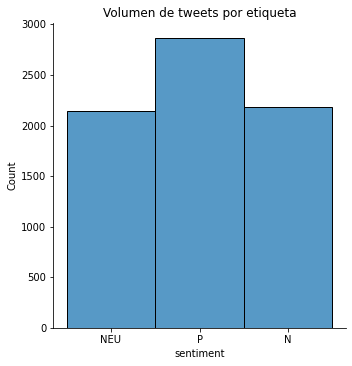

In [ ]:
# Comprobamos distribución de la etiqueta 'sentiment'
sns.displot(train_df.sentiment)
plt.title('Volumen de tweets por etiqueta');

print(train_df.sentiment.value_counts())
print('Tamaño del dataset:', train_df.shape)

In [ ]:
# Comprobamos nulls
print(train_df.isnull().sum())

content      0
sentiment    0
dtype: int64


In [ ]:
# ELiminamos nulls
train_df.dropna(inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [ ]:
train_df

,content,sentiment
0,"Salgo de #VeoTV , que día más largoooooo...",NEU
1,@PauladeLasHeras No te libraras de ayudar me/n...,NEU
2,@marodriguezb Gracias MAR,P
3,"Off pensando en el regalito Sinde, la que se v...",N
4,Conozco a alguien q es adicto al drama! Ja ja ...,P
...,...,...
7189,Muy indignante si ...nadie repara en ello hoy ...,N
7190,Más pobres por discriminar a la mujer http://t...,N
7191,Crean un banco de productos para mujeres con c...,P
7192,Sobre la sorprendente huída hoy en el Senado d...,N


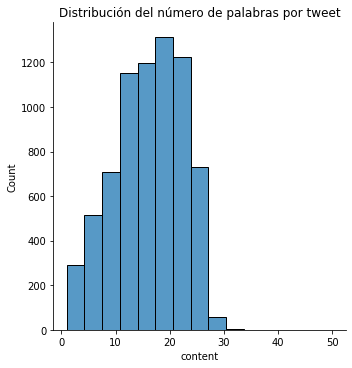

In [ ]:
def count_words(df):
    count = 0
    for word in df.split():
        count += 1
    return count

sns.displot(train_df['content'].apply(count_words), bins = 15)
plt.title('Distribución del número de palabras por tweet');

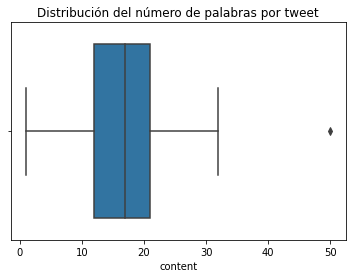

In [ ]:
sns.boxplot(train_df['content'].apply(count_words))
plt.title('Distribución del número de palabras por tweet');

###1.2 Datos de elecciones Perú

####Inicializar y métodos

In [ ]:
menciones = '@[\w\-]+'

In [ ]:
#ARREGLO CON CUENTAS OFICIALES CANDIDATOS Y PARTIDOS TWITTER
cuentasCandidatoPrimera = ['@Ollanta_HumalaT', '@vozdelatierra', '@julioguzmanperu', '@rafaelsantosn', '@George_Forsyth',
           '@yonhy_lescano', '@HDeSotoPeru', '@DanielUrresti1', '@Vero_Mendoza_F', '@BeingoleaA', 
           '@KeikoFujimori', '@EquipoVega', '@rlopezaliaga1', '@Ciro_GalvezH', '@dsalaverryv',
           '@PedroCastilloTe', '@aalacantarape', '@CesarAcunaP']
cuentasPartidoPrimera = ['@pnacionalistap', '@FrenteAmplioPe', '@partidomorado', '@pps_peru', '@VNoficial2021', '@AccionPopular',
            '@avanzapaisperu', '@podemos_peru', '@JuntosporPeru', '@ppc_peru', '@FuerzaPopular__', '@PeruUPP',
            '@Renovacion_Peru', '@Partido_RUNA', '@SomosPeruOf', '@PERU_LIBRE1', '@democraciadpe', '@Peru_APP']

cuentasCandidatoSegunda = ['@KeikoFujimori', '@PedroCastilloTe']
cuentasPartidoSegunda = ['@FuerzaPopular__', '@PERU_LIBRE1']

In [ ]:
#FUNCION PARA DIVIDIR DF EN 2 ARCHIVOS: TUITS CON MENSION Y SIN MENSION

def dividirDataMension(colTexto, ListaCuentas):
  mentioned_tweets = [] #TUITS CON MENSIONES
  no_mentioned_tweets = [] #TUITS SIN MENSIONES
  for content in colTexto.items():
    lista = re.findall(menciones, content[1])
    mens = 0
    for element in lista:
      for cuenta in ListaCuentas:
        if cuenta == element:
          mens+=1
    if mens == 1:
      mentioned_tweets.append(content[1])
    else:
      no_mentioned_tweets.append(content[1])

  return pd.DataFrame(mentioned_tweets), pd.DataFrame(no_mentioned_tweets)

In [ ]:
#FUNCION PARA AGREGAR LA MENSION Y LIMPIAR TEXTO

def addMentionClearText(DFconMencion, listaCuentas):
  #AGREGA LA NUEVA COLUMNA MENCION
  DFconMencion = DFconMencion.rename(columns= {0:'content'})
  DFconMencion['mencion'] = ""

  #CONVIERTE EL ARCHIVO CON MENSION EN DOS COLUMNAS: TEXTO Y MENSION
  i=0
  for content in DFconMencion["content"]:
    lista = re.findall(menciones, content)
    for element in lista:
      for cuenta in listaCuentas:
        if cuenta == element:
          DFconMencion.loc[i,'mencion'] = cuenta
    i+=1

  return DFconMencion

####Primera Vuelta

In [ ]:
#Cargamos la data
data = pd.read_csv('datosPrimeraCompleto.csv')
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Datetime,Text,Username
0,0,0,0,2021-03-28 23:58:20+00:00,@Ollanta_HumalaT Ánimos y éxitos 🤗🤗🤗,ayma_sayre
1,1,1,1,2021-03-28 23:56:48+00:00,@LuisRipas @Ollanta_HumalaT @Vero_Mendoza_F Cr...,checheboa
2,2,2,2,2021-03-28 23:54:52+00:00,@Ollanta_HumalaT Quién es tu amo?,Gianfranco_mna
3,3,3,3,2021-03-28 23:50:33+00:00,@Ollanta_HumalaT Necesito una foto así para mi...,Richaardavila
4,4,4,4,2021-03-28 23:47:18+00:00,@Ollanta_HumalaT Que debata tu perrito mejor.,Carmhuguet
...,...,...,...,...,...,...
81209,81209,40829,4996,2021-03-02 15:57:40+00:00,@SIGFREDOAQP @Fuerzadeley @Peru_APP @Alejandro...,chatavelit
81210,81210,40830,4997,2021-03-02 15:56:13+00:00,@dabugattas16 @Peru_APP Al parecer se quieren ...,jose_parra53
81211,81211,40831,4998,2021-03-02 15:55:55+00:00,"@dabugattas16 @Peru_APP Lee más, no caigas en ...",rmalaver
81212,81212,40832,4999,2021-03-02 15:55:00+00:00,@dabugattas16 @Peru_APP la cola se respeta.,jgcaverop


In [ ]:
#ELIMINACION DUPLICADO DE MISMA PERSONA
u_tweets = data.drop_duplicates('Username',keep='last')

#UTILIZAR SOLO LA COLUMNA TEXT
tuits = u_tweets.Text
# ELiminamos nulls
tuits.dropna(inplace = True)
tuits.reset_index(drop = True, inplace = True)
tuits

0        @Ollanta_HumalaT Necesito una foto así para mi...
1        @Ollanta_HumalaT Mi mamá votará por usted 😄 yo...
2        @Ollanta_HumalaT Los futuros juicios que tiene...
3        @Ollanta_HumalaT Y que paso con Nadine?? Ya no...
4        @diariocorreo @Ollanta_HumalaT No te pesan los...
                               ...                        
20173    @SIGFREDOAQP @Fuerzadeley @Peru_APP @Alejandro...
20174    @dabugattas16 @Peru_APP Al parecer se quieren ...
20175    @dabugattas16 @Peru_APP Lee más, no caigas en ...
20176          @dabugattas16 @Peru_APP la cola se respeta.
20177    @dabugattas16 @Peru_APP Qué tipo de gente para...
Name: Text, Length: 20178, dtype: object

In [ ]:
DFtcmPC,DFtsmPC = dividirDataMension(tuits, cuentasCandidatoPrimera)

#DFtcmPC = data frame tuits con mension Primera Candidato
#DFtsmPC = data frame tuits sin mension Primera Candidato

In [ ]:
DFtcmPC = addMentionClearText(DFtcmPC, cuentasCandidatoPrimera)

In [ ]:
DFtcmPC

,content,mencion
0,@Ollanta_HumalaT Necesito una foto así para mi...,@Ollanta_HumalaT
1,@Ollanta_HumalaT Mi mamá votará por usted 😄 yo...,@Ollanta_HumalaT
2,@Ollanta_HumalaT Los futuros juicios que tiene...,@Ollanta_HumalaT
3,@Ollanta_HumalaT Y que paso con Nadine?? Ya no...,@Ollanta_HumalaT
4,@diariocorreo @Ollanta_HumalaT No te pesan los...,@Ollanta_HumalaT
...,...,...
11652,@CesarAcunaP @Peru_APP ¿Ahí están los memes? T...,@CesarAcunaP
11653,@CesarAcunaP @Peru_APP Es de memes? La bajo so...,@CesarAcunaP
11654,@CesarAcunaP @Peru_APP Ni así me regalen megas,@CesarAcunaP
11655,@CesarAcunaP @Peru_APP No se olviden de visita...,@CesarAcunaP


####Segunda Vuelta

In [ ]:
#Cargamos la data
data = pd.read_csv('datosSegundaCompleto.csv')
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Datetime,Text,Username
0,0,0,0,2021-05-29 23:59:55+00:00,@chrisbustc @edisonflores135 @KeikoFujimori Es...,Philo05594171
1,1,1,1,2021-05-29 23:59:40+00:00,@Politico_pe @fuerzapopular @KeikoFujimori htt...,avancemossoto
2,2,2,2,2021-05-29 23:59:33+00:00,@KeikoFujimori @liliantintori @leopoldolopez Q...,pdiazperez
3,3,3,3,2021-05-29 23:59:28+00:00,@harrycomodoro @chrisbustc @KeikoFujimori ASI ES,ramm2011
4,4,4,4,2021-05-29 23:59:28+00:00,@KeikoFujimori @liliantintori @leopoldolopez O...,micky_svr
...,...,...,...,...,...,...
15002,15002,5000,4996,2021-05-21 04:48:10+00:00,@ilawiperu @CristhianRS @PERU_LIBRE1 Y los ter...,psvending1
15003,15003,5001,4997,2021-05-21 04:41:34+00:00,@PERU_LIBRE1 Qué bonitos militantes ah! Tambié...,Raquel71585851
15004,15004,5002,4998,2021-05-21 04:40:25+00:00,"@PERU_LIBRE1 No se cayó, se desplomó!",chukivoley
15005,15005,5003,4999,2021-05-21 04:38:18+00:00,"@mianvemo @PERU_LIBRE1 Yo tb, todos los profes...",Raquel71585851


In [ ]:
#ELIMINACION DUPLICADO DE MISMA PERSONA
u_tweets = data.drop_duplicates('Username',keep='last')

#UTILIZAR SOLO LA COLUMNA TEXT
tuits = u_tweets.Text
# ELiminamos nulls
tuits.dropna(inplace = True)
tuits.reset_index(drop = True, inplace = True)
tuits

0       @chrisbustc @edisonflores135 @KeikoFujimori Es...
1       @KeikoFujimori @liliantintori @leopoldolopez Q...
2       @KeikoFujimori @liliantintori @leopoldolopez O...
3       @fsanchezmolocho @rpadillafernan @AlertaNews24...
4       @benjami24108516 @canalN_ @KeikoFujimori Herma...
                              ...                        
7658    @contracultural Las plazas q llena @PedroCasti...
7659    @ilawiperu @CristhianRS @PERU_LIBRE1 Y los ter...
7660                @PERU_LIBRE1 No se cayó, se desplomó!
7661    @mianvemo @PERU_LIBRE1 Yo tb, todos los profes...
7662    @GuilleBermejo01 En @exitosape radio oficial d...
Name: Text, Length: 7663, dtype: object

In [ ]:
#dividimos los datos con mension
DFtcmSC,DFtsmSC = dividirDataMension(tuits, cuentasCandidatoSegunda)

#DFtcmSC = data frame tuits con mension Segunda Candidatos
#DFtsmP = data frame tuits sin mension Segunda

In [ ]:
#Agregamos columna de mensión al candidato
DFtcmSC = addMentionClearText(DFtcmSC, cuentasCandidatoSegunda)
DFtcmSC

,content,mencion
0,@chrisbustc @edisonflores135 @KeikoFujimori Es...,@KeikoFujimori
1,@KeikoFujimori @liliantintori @leopoldolopez Q...,@KeikoFujimori
2,@KeikoFujimori @liliantintori @leopoldolopez O...,@KeikoFujimori
3,@fsanchezmolocho @rpadillafernan @AlertaNews24...,@KeikoFujimori
4,@benjami24108516 @canalN_ @KeikoFujimori Herma...,@KeikoFujimori
...,...,...
4723,@Raygada_LuisE @VLADIMIR_CERRON @RPPNoticias @...,@KeikoFujimori
4724,@VLADIMIR_CERR0N @Raygada_LuisE @VLADIMIR_CERR...,@KeikoFujimori
4725,@leydelacalle @PedroCastilloTe @PERU_LIBRE1 Cl...,@PedroCastilloTe
4726,@Raygada_LuisE @VLADIMIR_CERRON @RPPNoticias @...,@KeikoFujimori


##2. Preprocesamiento

###2.1 Preprocessing: methods

In [ ]:
# Eliminamos signos de puntuación y sustituimos por espacios en blanco

def remove_punctuation_space(df):
    PUNCTUATION = re.compile("""(\-)|(\,)|(\..)|(\...)|(\....)|(\.....)|(\......)|(\.......)""")
    
    return " ".join([PUNCTUATION.sub(" ", word.lower()) for word in df.split()])

In [ ]:
# Eliminamos signos de puntuación sin reemplazo

def remove_punctuation(df):
    PUNCTUATION = re.compile("""(\.)|(\;)|(\:)|(\!)|(\?)|(\¡)|(\¿)| \
    (\")|(\()|(\))|(\[)|(\])|(\d+)|(\/)|(\“)|(\”)|(\')|(\-)|(\")|(\*)""")
    
    return " ".join([PUNCTUATION.sub("", word.lower()) for word in df.split()])

In [ ]:
# Corregimos abreviaciones
def fix_abbr(x):
    if type(x) == list:
        words = x
    elif type(x) == str:
        words = x.split()
    else:
        raise TypeError('El formato no es válido, debe ser lista o str')

    abbrevs = {'d': 'de',
               'x': 'por',
               'xa': 'para',
               'as': 'has',
               'q': 'que',
               'k': 'que',
               'dl': 'del',
               'xq': 'porqué',
               'dr': 'doctor',
               'dra': 'doctora',
               'sr': 'señor',
               'sra': 'señora',
               'm': 'me'}
    return " ".join([abbrevs[word] if word in abbrevs.keys() else word for word in words])

In [ ]:
# Eliminamos links
def remove_links(df):
    return " ".join([' ' if ('http') in word else word for word in df.split()])

In [ ]:
# Eliminamos vocales repetidas
    
def remove_repeated_vocals(df):
    
    list_new_word = []

    for word in df.split(): #separamos en palabras
        new_word = []
        pos = 0
        
        for letra in word: #separamos cada palabra en letras
            #print(word, letra, pos, '-', new_word)
            if pos>0:
                if letra in ('a', 'e', 'i', 'o', 'u') and letra == new_word[pos-1]:
                    None
                else:
                    new_word.append(letra)
                    pos +=1
            else:
                new_word.append(letra)
            
                pos += 1
        else:
            list_new_word.append("".join(new_word))
                
    return " ".join(list_new_word)

In [ ]:
# Normalizamos risas 'jajaja', 'jejeje', 'jojojo'
    
def normalize_laughts(df):
    
    list_new_words = []
    for word in df.split(): #separamos en palabras
        count = 0
        vocals_dicc = {'a': 0, 'e': 0, 'i': 0, 'o':0, 'u':0}
        
        for letra in word:
            #print(word)
            if letra == 'j':
                count+=1
            if letra in vocals_dicc.keys():
                vocals_dicc[letra] += 1
        else:
            if count>3:
                dicc_risa = {'a': 'jaja', 'e': 'jeje', 'i': 'jiji', 'o': 'jojo', 'u': 'juju'}
                risa_type = max(vocals_dicc, key= lambda x: vocals_dicc[x]) #Indica si es a,e,i,o,u
                list_new_words.append(dicc_risa[risa_type])
            else:
                list_new_words.append(word)
    
    return " ".join(list_new_words)

In [ ]:
# Eliminamos hashtags
def remove_hashtags(df):
    return " ".join([' ' if word.startswith('#') else word for word in df.split()])

In [ ]:
# Eliminamos menciones
def remove_mentions(df):
    return " ".join([' ' if word.startswith('“@') or word.startswith('@') else word for word in df.split()])

In [ ]:
# Función para identificar los 'emojis' tradicionales

def transform_icons(df):
    word_list = []
    pos_emojis = [':)', ':D', ':))', ':)))', 'xD', 'xd', 'XD']
    neg_emojis = [':(', ":'(", '>:(', ':,(', ":(("]
    for word in df.split():
        if word in neg_emojis:
            word = '{emoji_neg}'
            word_list.append(word)
        elif word in pos_emojis:
            word = '{emoji_pos}'
            word_list.append(word)
        elif ':O' in word:
            word = '{emoji_neu}'
            word_list.append(word)
        else:
            word_list.append(word)
    return " ".join(word_list)

In [ ]:
# Separamos emojis que vengan juntos
def sep_emojis(df):
    words_list = []
    for token in df.split():
        new_word = []
        for letra in token:
          #emoji.UNICODE_EMOJI['es']
            if emoji.distinct_emoji_list(letra):
                words_list.append(letra)
            else:
                new_word.append(letra)
        else:
            words_list.append("".join(new_word))

    return " ".join(word for word in words_list if word != '')

In [ ]:
# Creamos diccionario de emojis
import csv

def _build_dict_from_csv(csv_path):
    """ Fork basado en emosent-py de Fintel Labs Inc. """

    emoji_sentiment_rankings = {}

    with open(csv_path, newline='', encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file)
        _header_row = next(csv_reader)
        for row in csv_reader:
            emoji = row[0]
            unicode_codepoint = row[1]
            occurrences = int(row[2])
            negative = float(row[4])
            neutral = float(row[5])
            positive = float(row[6])

            emoji_sentiment_rankings[unicode_codepoint] = {
                'emoji': emoji,
                'occurrences': occurrences,
                'sentiment': [negative, neutral, positive]
            }

    return emoji_sentiment_rankings

EMOJI_SENTIMENT_DICT = _build_dict_from_csv('Emoji_Sentiment_Data_v1.0.csv')

In [ ]:
# Definimos función para identificar sentimiento del emoji
from emosent import get_emoji_sentiment_rank
import emoji

# Devuelve true/false si es emoji
def char_is_emoji(character):
    #return character in emoji.UNICODE_EMOJI['es']
    return emoji.distinct_emoji_list(character)

# DEPRECATED - Devuelve si un emoji es neg/pos/neutro o no identificado
def sentiment_emoji(emoji):
    try:
        sentiment = get_emoji_sentiment_rank(emoji)['sentiment_score']
        if sentiment < -0.3:
            return '{emoji_neg}'
        elif sentiment < 0.3:
            return '{emoji_neu}'
        elif sentiment >= 0.3:
            return '{emoji_pos}'
    except:
        return '{emoji_na}'
    
# Devuelve si un emoji es neg/pos/neutro o no identificado
def get_emoji_rank(emoji):
    
    emoji = f'0x{ord(emoji[0]):X}'.lower()
    
    if emoji in EMOJI_SENTIMENT_DICT.keys():
        if EMOJI_SENTIMENT_DICT[emoji]['occurrences'] > 80:
            if np.argmax(EMOJI_SENTIMENT_DICT[emoji]['sentiment']) == 0:
                return '{emoji_neg}'
            elif np.argmax(EMOJI_SENTIMENT_DICT[emoji]['sentiment']) == 1:
                return '{emoji_neu}'
            else:
                return '{emoji_pos}'
        else:
            return '{emoji_neu}'
    else:
        return '{emoji_neu}'

def transform_emoji(df):
    return " ".join([get_emoji_rank(word) if char_is_emoji(word) else word for word in df.split()])

In [ ]:
# Eliminamos stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')
non_stopwords = ['no', 'ni', 'poco', 'mucho', 'nada', 'muchos', 'muy', 'nosotros',
                 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ella', 'él', 'tu', 'tú', 'yo',
                 'pero', 'hasta', 'contra', 'por']
spanish_stopwords = [word for word in stopwords.words('spanish') if word not in non_stopwords]

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Función para lematizar

# Creamos el objeto
import spacy
from spacy.lang.es.examples import sentences 
#from spacy import es_core_news_md
#nlp = spacy.load('es_core_news_md')

import es_core_news_md
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = es_core_news_md.load()

# Definimos función
def lemmatizer(df):
    word_list = []
    doc = nlp(df)
    for tok in doc:
        if str(tok) == 'menc':
              word_list.append('{menc}')
        elif str(tok) == 'hash':
              word_list.append('{hash}')
        elif str(tok) == 'link':
              word_list.append('{link}')
        elif str(tok) == 'emoji_pos':
              word_list.append('{emoji_pos}')
        elif str(tok) == 'emoji_neu':
              word_list.append('{emoji_neu}')
        elif str(tok) == 'emoji_neg':
              word_list.append('{emoji_neg}')
        elif str(tok) == 'eur':
              word_list.append('{eur}')
        else:
            word_list.append(tok.lemma_.lower())

    return " ".join([word for word in word_list if (word != '{') and (word!='}')])  

In [ ]:
spell = SpellChecker(language='es', distance=1)

def correcting_words(df):
    misspelled = spell.unknown(df.split())
    #return " ".join([spell.correction(word) if word in misspelled else word for word in df.split()])
    return str([spell.correction(word) if word in misspelled else word for word in df.split()])

In [ ]:
def remove_money(df):
    wlist = [' ' if ('€' in word) | ('soles' in word) | ('dolares' in word) | ('$' in word) else word for word in df.split()]
    return " ".join(wlist)

###2.2 Preprocessing: Train dataset

In [ ]:
# Put it all together

def transform_tweets(df, mode='lemma'):
    
    df = remove_links(df)
    df = remove_punctuation_space(df)
    df = remove_mentions(df)    
    df = remove_hashtags(df)
    df = remove_money(df)
    df = transform_icons(df)
    df = sep_emojis(df)
    df = transform_emoji(df)
    df = normalize_laughts(df)
    df = remove_punctuation(df)
    df = remove_repeated_vocals(df)
    #df = correcting_words(df)
    df = fix_abbr(df)
    df = remove_stopwords(df)
    if mode=='lemma':
        df = lemmatizer(df)
    elif mode=='stem':
        df = stem(df)
    else:
        raise TypeError('Invalid mode. Must be "lemma" or "stem"') 
                        
    return df

In [ ]:
%%time
# Aplicamos a datos de entrenamiento
train_df.content = train_df.content.apply(transform_tweets, mode='lemma')

CPU times: user 1min 13s, sys: 364 ms, total: 1min 14s
Wall time: 1min 14s


In [ ]:
train_df

,content,sentiment
0,salgo día largo,NEU
1,no librara ayudar menos beso gracia,NEU
2,gracia mar,P
3,off pensar regalito sinde ir sgae ir corrupto ...,N
4,conocer alguien adicto drama ja ja ja sonar,P
...,...,...
7189,mucho indignante si adie repar él hoy aqui gra...,N
7190,pobre por discriminar mujer,N
7191,crear banco producto mujeres cáncer mama,P
7192,sorprendente huída hoy senado rajoy,N


###2.3 Preprocessing: Election dataset

####Primera Vuelta

In [ ]:
%%time
# Aplicamos a datos de elecciones
DFtcmPC.content = DFtcmPC.content.apply(transform_tweets, mode='lemma')

CPU times: user 1min 56s, sys: 470 ms, total: 1min 57s
Wall time: 1min 57s


In [ ]:
DFtcmPC

,content,mencion
0,necesitar foto así instagram,@Ollanta_HumalaT
1,mamá votar por usted {emoji_pos} yo aún no def...,@Ollanta_HumalaT
2,futuro juicio pendiente,@Ollanta_HumalaT
3,paso nadine no acompañar,@Ollanta_HumalaT
4,no pesar cuerno,@Ollanta_HumalaT
...,...,...
11652,ahí mem tu ah,@CesarAcunaP
11653,mem bajo solo si mem {emoji_neu} {emoji_neu},@CesarAcunaP
11654,ni así regalir megas,@CesarAcunaP
11655,no olvidar visitar sección humorístico memes m...,@CesarAcunaP


####Segunda Vuelta

In [ ]:
%%time
# Aplicamos a datos de elecciones
DFtcmSC.content = DFtcmSC.content.apply(transform_tweets, mode='lemma')

CPU times: user 47.4 s, sys: 241 ms, total: 47.6 s
Wall time: 48.2 s


In [ ]:
DFtcmSC

,content,mencion
0,desubicado hoy cre capitalista despues tragar ...,@KeikoFujimori
1,tal ostra,@KeikoFujimori
2,oir cara duro no ninguno extranjero deber mete...,@KeikoFujimori
3,comunista {emoji_neu} {emoji_neu} {emoji_neu} ...,@KeikoFujimori
4,hermano comera mierda guardar twitt,@KeikoFujimori
...,...,...
4723,no esconda,@KeikoFujimori
4724,{emoji_pos} {emoji_pos},@KeikoFujimori
4725,claro ahora no agredir reportero willax no tir...,@PedroCastilloTe
4726,lamentable decir mucho posible gobierno tú mac...,@KeikoFujimori


##3. Entrenamiento del modelo

Mediante una prueba externa, se analizó el dataset mediante multiples modelos, por lo cual resultó como ganador las Redes Neuronales Recurrentes utilizando capas Bidireccionales

In [ ]:
# Número de palabras del modelo
tokens = set()
for tweet in train_df.content:
    for word in tweet.split():
        tokens.add(word)
dim = len(tokens)        
print('Número total de palabras:', dim)

Número total de palabras: 12717


In [ ]:
INPUT_LENGTH = 25
EMBED_DIM = 128
#MAX_WORDS = dim
MAX_LEN = 200

# Creamos tokenizador
tokenizer = keras.preprocessing.text.Tokenizer(num_words = dim)
tokenizer.fit_on_texts(train_df.content)
sequences = tokenizer.texts_to_sequences(train_df.content)
X = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen = INPUT_LENGTH
)
y = pd.get_dummies(train_df.sentiment).values

In [ ]:
print('Shape X:', X.shape)
print('Shape y:', y.shape)

Shape X: (7194, 25)
Shape y: (7194, 3)


In [ ]:
DROPOUT_VAL = 0.6

layers = [
    keras.layers.Embedding(dim, 40, input_length = INPUT_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(20, dropout = DROPOUT_VAL)),
    keras.layers.Dense(3, activation = 'softmax')
]

model3 = keras.models.Sequential(layers)

# Compilamos modelo
model3.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

# Creamos faststopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         mode = 'min',
                                         verbose = 0,
                                         patience = 3)
# Creamos checkpoint
checkpoint_3 = keras.callbacks.ModelCheckpoint('best_model3.hdf5',
                                     monitor = 'val_accuracy',
                                     verbose = 1,
                                     save_best_only = True,
                                     mode = 'auto',
                                     save_weigths_only = False)


In [ ]:
# Separamos train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    test_size = 0.15)

In [ ]:
EPOCHS = 20

In [ ]:
# Entrenamos
history_3 = model3.fit(X_train,
                       y_train,
                       epochs = EPOCHS,
                       validation_data = (X_test, y_test),
                       batch_size = 16,
                       callbacks = [callback, checkpoint_3])

Epoch 1/20
382/383 [============================>.] - ETA: 0s - loss: 1.0504 - accuracy: 0.4488
Epoch 1: val_accuracy improved from -inf to 0.49537, saving model to best_model3.hdf5
383/383 [==============================] - 14s 23ms/step - loss: 1.0503 - accuracy: 0.4488 - val_loss: 1.0115 - val_accuracy: 0.4954
Epoch 2/20
383/383 [==============================] - ETA: 0s - loss: 0.9245 - accuracy: 0.5608
Epoch 2: val_accuracy improved from 0.49537 to 0.54815, saving model to best_model3.hdf5
383/383 [==============================] - 8s 20ms/step - loss: 0.9245 - accuracy: 0.5608 - val_loss: 0.9264 - val_accuracy: 0.5481
Epoch 3/20
382/383 [============================>.] - ETA: 0s - loss: 0.7960 - accuracy: 0.6446
Epoch 3: val_accuracy improved from 0.54815 to 0.59352, saving model to best_model3.hdf5
383/383 [==============================] - 8s 21ms/step - loss: 0.7960 - accuracy: 0.6446 - val_loss: 0.8945 - val_accuracy: 0.5935
Epoch 4/20
381/383 [============================>.]

In [ ]:
 #Evaluamos
accuracy_dl_bi = model3.evaluate(X_test, y_test)
accuracy_dl_bi

34/34 [==============================] - 0s 6ms/step - loss: 0.9874 - accuracy: 0.6111


[0.9873778223991394, 0.6111111044883728]

In [ ]:
# Sacamos classification report
y_pred_3 = model3.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_3, axis=1)))

34/34 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       334
           1       0.59      0.49      0.54       337
           2       0.60      0.77      0.68       409

    accuracy                           0.61      1080
   macro avg       0.62      0.60      0.60      1080
weighted avg       0.61      0.61      0.61      1080



In [ ]:
train_df

,content,sentiment
0,salgo día largo,NEU
1,no librara ayudar menos beso gracia,NEU
2,gracia mar,P
3,off pensar regalito sinde ir sgae ir corrupto ...,N
4,conocer alguien adicto drama ja ja ja sonar,P
...,...,...
7189,mucho indignante si adie repar él hoy aqui gra...,N
7190,pobre por discriminar mujer,N
7191,crear banco producto mujeres cáncer mama,P
7192,sorprendente huída hoy senado rajoy,N


In [ ]:
from sklearn.metrics import confusion_matrix

def display_cm(y_test, y_pred):    
    sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize = 'true'),
                annot = True, cmap = 'Blues', fmt='g', cbar=False)
    plt.title('Real vs pred')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values');
    
    plt.show()

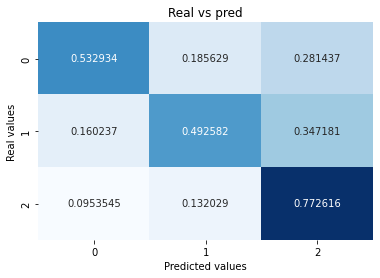

In [ ]:
display_cm(y_test, y_pred_3)

In [ ]:
accuracy_dl_bi[1]

0.6111111044883728

##4. Ejecutar el modelo con datos electorales

###4.1 Metodos para predicción

####Predecir en texto plano

In [ ]:
# Función para establecer el threshold en 0.5
def get_label_predict(probas, i=0.5):
    if np.argmax(probas)==0:
        return 0
    elif np.argmax(probas)==2:
        return 4
    elif np.argmax(probas)==1 and probas[1]<i:
        if probas[2] > probas[0]:
            return 3
        else:
            return 1
    else:
        return 2

In [ ]:
#Tokenizar Texto
def text_tokenizer(text):
  list = []
  list.append(text)
  text = pd.DataFrame(list)
  #print(text)
  sequences = tokenizer.texts_to_sequences(text.iloc[0])
  
  text_tokenized = keras.preprocessing.sequence.pad_sequences(sequences,maxlen = INPUT_LENGTH)
  return text_tokenized

In [ ]:
#Predecir en texto plano
def predict_text(text):
  sentiment = ['Negativo', 'Neutro-negativo', 'Neutro', 'Neutro-positivo','Positivo']
  x = text_tokenizer(text)  
  print(model3.predict(x))
  print('Tweet sentiment:', sentiment[get_label_predict(model3.predict(x)[0])])

In [ ]:
predict_text('ganaremos con el apoyo del pueblo')

1/1 [==============================] - 0s 27ms/step
[[0.12148973 0.1927679  0.6857424 ]]
1/1 [==============================] - 0s 20ms/step
Tweet sentiment: Positivo


In [ ]:
predict_text('elecciones del peru')

1/1 [==============================] - 0s 20ms/step
[[0.06389683 0.6763129  0.25979024]]
1/1 [==============================] - 0s 17ms/step
Tweet sentiment: Neutro


####Predecir en DF

In [ ]:
palabra = ['una mala gestion en el pasado','con fe ganamos las elecciones','estamos listos para todo']

In [ ]:
new = pd.DataFrame(palabra)
new.columns = ['content']
new

,content
0,una mala gestion en el pasado
1,con fe ganamos las elecciones
2,estamos listos para todo


In [ ]:
#Tokenizar Data Frame
def df_tokenizer(df):
  sequences = tokenizer.texts_to_sequences(df.content)
  df_tokenized = keras.preprocessing.sequence.pad_sequences(sequences,maxlen = INPUT_LENGTH)
  return df_tokenized

In [ ]:
#Predecir Data Frame
def predict_df(df):
  sentiment = ['NEG', 'NEG', 'NEU', 'POS','POS']
  x = df_tokenizer(df) 
  sent_text = [] 
  sent_prob = model3.predict(x)
  for a in sent_prob:
    #print(a)
    sent_text.append(sentiment[get_label_predict(a)])
  df['sentiment_pred'] = sent_text
  return df

In [ ]:
x_new = predict_df(new)
x_new

1/1 [==============================] - 0s 21ms/step


,content,sentiment_pred
0,una mala gestion en el pasado,NEG
1,con fe ganamos las elecciones,NEU
2,estamos listos para todo,POS


###4.2 Predecir df Elecciones

####Primera Vuelta

In [ ]:
df_elecciones_pred_pv = predict_df(DFtcmPC)

365/365 [==============================] - 2s 4ms/step


In [ ]:
df_elecciones_pred_pv

,content,mencion,sentiment_pred
0,necesitar foto así instagram,@Ollanta_HumalaT,NEG
1,mamá votar por usted {emoji_pos} yo aún no def...,@Ollanta_HumalaT,POS
2,futuro juicio pendiente,@Ollanta_HumalaT,NEU
3,paso nadine no acompañar,@Ollanta_HumalaT,POS
4,no pesar cuerno,@Ollanta_HumalaT,NEG
...,...,...,...
11652,ahí mem tu ah,@CesarAcunaP,NEU
11653,mem bajo solo si mem {emoji_neu} {emoji_neu},@CesarAcunaP,NEU
11654,ni así regalir megas,@CesarAcunaP,NEG
11655,no olvidar visitar sección humorístico memes m...,@CesarAcunaP,POS


####Segunda Vuelta

In [ ]:
df_elecciones_pred_sv = predict_df(DFtcmSC)

148/148 [==============================] - 1s 4ms/step


In [ ]:
df_elecciones_pred_sv

,content,mencion,sentiment_pred
0,desubicado hoy cre capitalista despues tragar ...,@KeikoFujimori,NEG
1,tal ostra,@KeikoFujimori,NEU
2,oir cara duro no ninguno extranjero deber mete...,@KeikoFujimori,NEG
3,comunista {emoji_neu} {emoji_neu} {emoji_neu} ...,@KeikoFujimori,POS
4,hermano comera mierda guardar twitt,@KeikoFujimori,NEG
...,...,...,...
4723,no esconda,@KeikoFujimori,NEU
4724,{emoji_pos} {emoji_pos},@KeikoFujimori,POS
4725,claro ahora no agredir reportero willax no tir...,@PedroCastilloTe,NEG
4726,lamentable decir mucho posible gobierno tú mac...,@KeikoFujimori,NEG


##5. Resultados y estadísticas

In [ ]:
#FUNCION PARA MOSTRAR ESTADISTICAS
def mostrarGraficoBarras(dataDF, height, widht, title, msjx, msjy):
  plt.figure(figsize=(widht, height)) 
  plots = sns.barplot(x=0, y=1, data=dataDF) 

  for bar in plots.patches: 
      plots.annotate(format(bar.get_height(), '.1f'),  
                    (bar.get_x() + bar.get_width() / 2,  
                      bar.get_height()), ha='center', va='center', 
                    size=15, xytext=(0, 8), 
                    textcoords='offset points')

  plt.xlabel(msjx, size=15) 
  plt.ylabel(msjy, size=15) 
  plt.title(title) 
  plt.show()

###5.1 Primera Vuelta

In [ ]:
#Usamos solo los tuits positivos
Resultados_PV = df_elecciones_pred_pv.loc[(df_elecciones_pred_pv.sentiment_pred == 'POS')]
Resultados_PV.reset_index(drop = True, inplace = True)

In [ ]:
Resultados_PV

In [ ]:
Resultados_PV.head()

,content,mencion,sentiment_pred
0,mamá votar por usted {emoji_pos} yo aún no def...,@Ollanta_HumalaT,POS
1,paso nadine no acompañar,@Ollanta_HumalaT,POS
2,tu futuro hacer dueño gremco delincuente saco ...,@Ollanta_HumalaT,POS
3,buen foto ollanto,@Ollanta_HumalaT,POS
4,año no hacer nada por perú ahora querer oportu...,@Ollanta_HumalaT,POS


In [ ]:
#HACER CONTEO DE LA CANTIDAD REFERENCIADA POR CANDIDATO O PARTIDO
counter=collections.Counter(Resultados_PV['mencion'])
counter

Counter({'@Ollanta_HumalaT': 251,
         '@vozdelatierra': 135,
         '@julioguzmanperu': 424,
         '@rafaelsantosn': 72,
         '@George_Forsyth': 218,
         '@yonhy_lescano': 189,
         '@HDeSotoPeru': 418,
         '@DanielUrresti1': 377,
         '@Vero_Mendoza_F': 506,
         '@BeingoleaA': 339,
         '@KeikoFujimori': 271,
         '@rlopezaliaga1': 798,
         '@dsalaverryv': 229,
         '@PedroCastilloTe': 6,
         '@aalacantarape': 7,
         '@CesarAcunaP': 1025})

In [ ]:
#CONVERTIR LA CANTIDAD A PORCENTAJES
cantidad = len(Resultados_PV['mencion'])
for item in counter:
  counter[item] = round((counter[item] * 100)/cantidad, 1)
counter 

Counter({'@Ollanta_HumalaT': 4.8,
         '@vozdelatierra': 2.6,
         '@julioguzmanperu': 8.1,
         '@rafaelsantosn': 1.4,
         '@George_Forsyth': 4.1,
         '@yonhy_lescano': 3.6,
         '@HDeSotoPeru': 7.9,
         '@DanielUrresti1': 7.2,
         '@Vero_Mendoza_F': 9.6,
         '@BeingoleaA': 6.4,
         '@KeikoFujimori': 5.1,
         '@rlopezaliaga1': 15.2,
         '@dsalaverryv': 4.3,
         '@PedroCastilloTe': 0.1,
         '@aalacantarape': 0.1,
         '@CesarAcunaP': 19.5})

In [ ]:
#Ordenando el diccionario
counterOrdenado = sorted(counter.items(), key=itemgetter(1), reverse=True)
df_pv = pd.DataFrame(counterOrdenado)
df_pv

,0,1
0,@CesarAcunaP,19.5
1,@rlopezaliaga1,15.2
2,@Vero_Mendoza_F,9.6
3,@julioguzmanperu,8.1
4,@HDeSotoPeru,7.9
5,@DanielUrresti1,7.2
6,@BeingoleaA,6.4
7,@KeikoFujimori,5.1
8,@Ollanta_HumalaT,4.8
9,@dsalaverryv,4.3


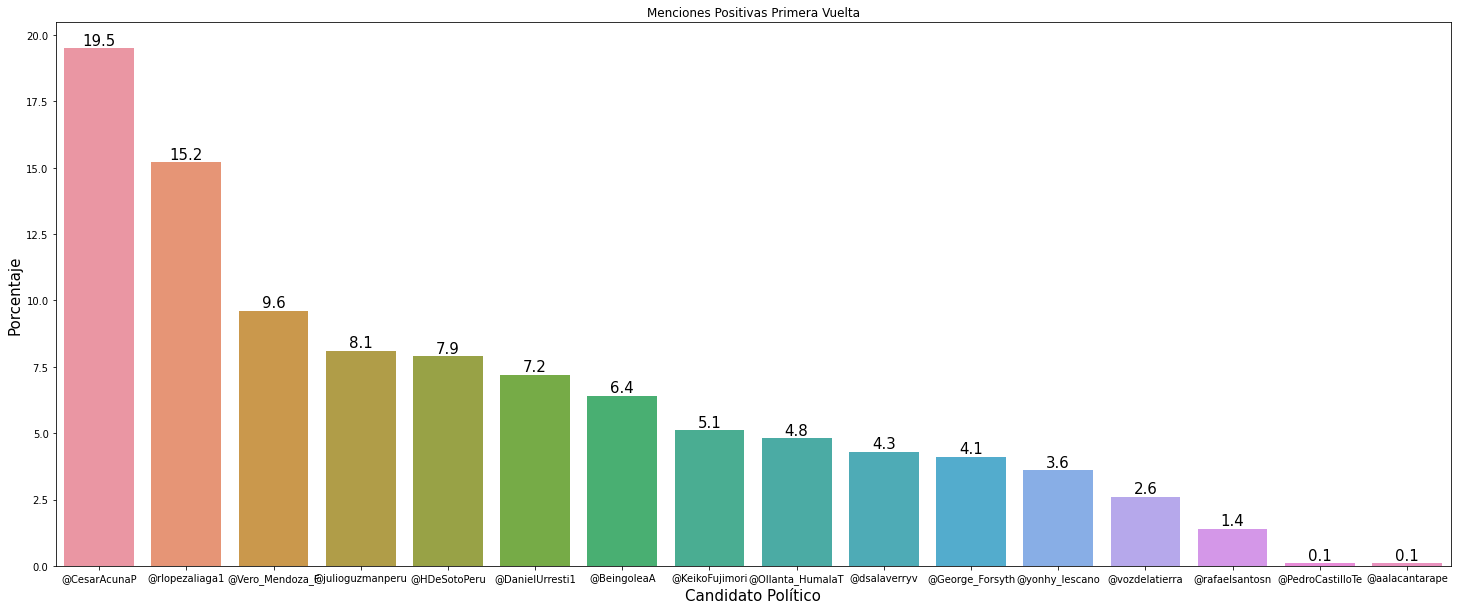

In [ ]:
#PARA EL CASO DE CUENTAS POR PARTIDO
mostrarGraficoBarras(df_pv, 10, 25,'Menciones Positivas Primera Vuelta','Candidato Político', 'Porcentaje')

###5.2 Segunda Vuelta

In [ ]:
#Usamos solo los tuits positivos
Resultados_SV = df_elecciones_pred_sv.loc[(df_elecciones_pred_sv.sentiment_pred == 'POS')]
Resultados_SV.reset_index(drop = True, inplace = True)

In [ ]:
Resultados_SV

,content,mencion,sentiment_pred
0,comunista {emoji_neu} {emoji_neu} {emoji_neu} ...,@KeikoFujimori,POS
1,discurso hablariar brote xenofobio sufrido tan...,@KeikoFujimori,POS
2,bienvenido ambos luchar por democracia,@KeikoFujimori,POS
3,por favor pedir compartar información publico ...,@KeikoFujimori,POS
4,ayyy doña luz penar por usted perú no merecer ...,@KeikoFujimori,POS
...,...,...,...
1490,sumamente desesperado por lado dar él campaña ...,@PedroCastilloTe,POS
1491,hola acabar encontrar publicidad engañoso algu...,@PedroCastilloTe,POS
1492,exacto partido % terrorista vinculado,@KeikoFujimori,POS
1493,pensar riesgo necesitar no volver yo fanático ...,@PedroCastilloTe,POS


In [ ]:
Resultados_SV.head()

,content,mencion,sentiment_pred
0,comunista {emoji_neu} {emoji_neu} {emoji_neu} ...,@KeikoFujimori,POS
1,discurso hablariar brote xenofobio sufrido tan...,@KeikoFujimori,POS
2,bienvenido ambos luchar por democracia,@KeikoFujimori,POS
3,ayyy doña luz penar por usted perú no merecer ...,@KeikoFujimori,POS
4,mal keiko actitud perdiste varios voto {emoji_...,@KeikoFujimori,POS


In [ ]:
#HACER CONTEO DE LA CANTIDAD REFERENCIADA POR CANDIDATO O PARTIDO
counter=collections.Counter(Resultados_SV['mencion'])
counter

Counter({'@KeikoFujimori': 746, '@PedroCastilloTe': 830})

In [ ]:
#CONVERTIR LA CANTIDAD A PORCENTAJES
cantidad = len(Resultados_SV['mencion'])
for item in counter:
  counter[item] = round((counter[item] * 100)/cantidad, 1)
counter 

Counter({'@KeikoFujimori': 47.3, '@PedroCastilloTe': 52.7})

In [ ]:
#Ordenando el diccionario
counterOrdenado = sorted(counter.items(), key=itemgetter(1), reverse=True)
df_sv = pd.DataFrame(counterOrdenado)
df_sv

,0,1
0,@PedroCastilloTe,52.7
1,@KeikoFujimori,47.3


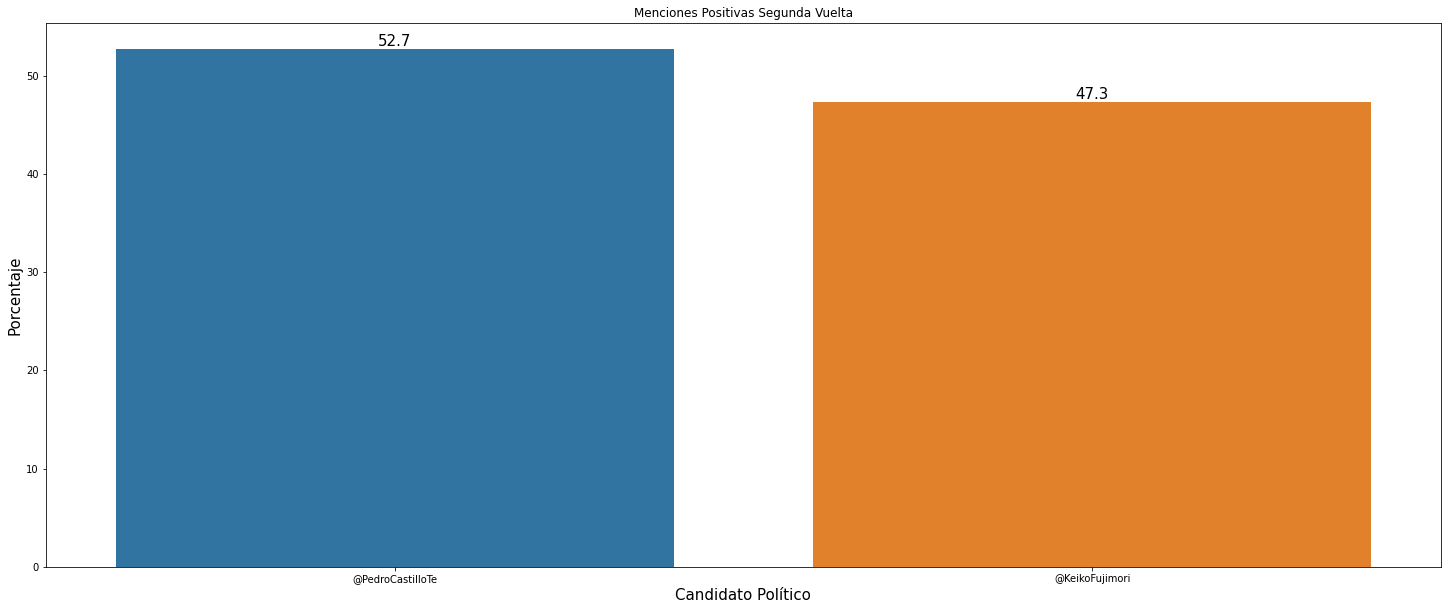

In [ ]:
#PARA EL CASO DE CUENTAS POR PARTIDO
mostrarGraficoBarras(df_sv, 10, 25,'Menciones Positivas Segunda Vuelta','Candidato Político', 'Porcentaje')

##6. Medidas de error

###6.1 RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Usando el valor promedio de las encuestadoras

In [ ]:
#UTILIZANDO EL PROMEDIO
#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais', 'Perú Libre']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]#[9.092, 5.639, 13.399, 11.641, 7.805, 11.607, 19.061]

y_encuestadoras_pv = [13.3, 8.9, 7.86, 7.23, 6.5, 5.26, 4]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 0.1]

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv          = [50.126, 49.874]
y_encuestadoras_sv = [50.442, 49.558]
y_modelo_sv        = [52.7, 47.3]

#POR POSICIONES
#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais', 'Perú Libre']
y_onpe_pv_pos          = [5, 8, 2, 3, 6, 4, 1]
y_encuestadoras_pv_pos = [1, 2, 3, 4, 5, 6, 7]
y_modelo_pv_pos        = [12, 11, 7, 2, 3, 5, 15]

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv_pos          = [1, 2]
y_encuestadoras_sv_pos = [1, 2]
y_modelo_sv_pos        = [1, 2]

#PORCENTAJE
print('PRIMERA VUELTA POR PORCENTAJE')
print('RMSE Encuestadora: ', mean_squared_error(y_onpe_pv, y_encuestadoras_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

print('\nSEGUNDA VUELTA POR PORCENTAJE')
print('RMSE Encuestadora: ', mean_squared_error(y_onpe_sv, y_encuestadoras_sv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_sv, y_modelo_sv, squared=False))

#POSICION
print('\n\nPRIMERA VUELTA POR POSICION')
print('RMSE Encuestadora: ', mean_squared_error(y_onpe_pv_pos, y_encuestadoras_pv_pos, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv_pos, y_modelo_pv_pos, squared=False))

print('\nSEGUNDA VUELTA POR POSICION')
print('RMSE Encuestadora: ', mean_squared_error(y_onpe_sv_pos, y_encuestadoras_sv_pos, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_sv_pos, y_modelo_sv_pos, squared=False))

PRIMERA VUELTA POR PORCENTAJE
RMSE Encuestadora:  7.01673559631339
RMSE Modelo:  8.318466282056702

SEGUNDA VUELTA POR PORCENTAJE
RMSE Encuestadora:  0.3160000000000025
RMSE Modelo:  2.574000000000005


PRIMERA VUELTA POR POSICION
RMSE Encuestadora:  3.6839419880650364
RMSE Modelo:  6.436503043467892

SEGUNDA VUELTA POR POSICION
RMSE Encuestadora:  0.0
RMSE Modelo:  0.0


In [ ]:
#UTILIZANDO EL PROMEDIO, SIN CASTILLO

#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626]
y_encuestadoras_pv = [13.3, 8.9, 7.86, 7.23, 6.5, 5.26]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9]

#POR POSICIONES
#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais', 'Perú Libre']
y_onpe_pv_pos          = [5, 8, 2, 3, 6, 4]
y_encuestadoras_pv_pos = [1, 2, 3, 4, 5, 6]
y_modelo_pv_pos        = [12, 11, 7, 2, 3, 5]

#PORCENTAJE
print('PRIMERA VUELTA POR PORCENTAJE SIN CASTILLO')
print('RMSE Encuestadora: ', mean_squared_error(y_onpe_pv, y_encuestadoras_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#POSICION
print('\nPRIMERA VUELTA POR POSICION SIN CASTILLO')
print('RMSE Encuestadora: ', mean_squared_error(y_onpe_pv_pos, y_encuestadoras_pv_pos, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv_pos, y_modelo_pv_pos, squared=False))

PRIMERA VUELTA POR PORCENTAJE SIN CASTILLO
RMSE Encuestadora:  4.509357086474005
RMSE Modelo:  4.6573978428588925

PRIMERA VUELTA POR POSICION SIN CASTILLO
RMSE Encuestadora:  3.13581462037113
RMSE Modelo:  3.958114029012639


Calculando el error por cada encuestadora

In [ ]:
print('PRIMERA VUELTA POR CADA ENCUESTADORA\n\n')
#Según porcentaje
print('Según Porcentaje\n')
#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Acuña']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 6.021]
y_cit_pv           = [9.4,8.2,7.7,13.4,6.1,10.2,6.1]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 19.5]
print('RMSE CIT: ', mean_squared_error(y_onpe_pv, y_cit_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]
y_cpi_pv           = [11.0, 8.1, 7.1, 5.2, 5.4, 4.5, 4.3]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 0.1]
print('\nRMSE CPI: ', mean_squared_error(y_onpe_pv, y_cpi_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]
y_datum_pv           = [12.1, 7.4, 7.9, 7.2, 5.7, 6.5, 3.7]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 0.1]
print('\nRMSE DATUM: ', mean_squared_error(y_onpe_pv, y_datum_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626]
y_ipsos_pv           = [16.8, 11.2, 8.6, 9.3, 8.4, 4.8]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9]
print('\nRMSE IPSOS: ', mean_squared_error(y_onpe_pv, y_ipsos_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))



print('\n\nSegún Posición\n')
#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_cit_pv           = [3,4,5,1,7,2]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('RMSE CIT: ', mean_squared_error(y_onpe_pv, y_cit_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 1]
y_cpi_pv           = [1,2,3,5,4,6,7]
y_modelo_pv        = [12, 11, 7, 2, 3, 5,15]
print('\nRMSE CPI: ', mean_squared_error(y_onpe_pv, y_cpi_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 1]
y_datum_pv         = [1,3,2,4,6,5, 7]
y_modelo_pv        = [12, 11, 7, 2, 3, 5,15]
print('\nRMSE DATUM: ', mean_squared_error(y_onpe_pv, y_datum_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto','urresti']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 8]
y_ipsos_pv         = [1,2,4,3,5,7,6]
y_modelo_pv        = [12, 11, 7, 2, 3, 5, 6]
print('\nRMSE IPSOS: ', mean_squared_error(y_onpe_pv, y_ipsos_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

PRIMERA VUELTA POR CADA ENCUESTADORA


Según Porcentaje

RMSE CIT:  2.591860032596558
RMSE Modelo:  6.674381394556352

RMSE CPI:  7.201366626253261
RMSE Modelo:  8.318466282056702

RMSE DATUM:  6.8232477499459785
RMSE Modelo:  8.318466282056702

RMSE IPSOS:  5.267328987890036
RMSE Modelo:  4.6573978428588925


Según Posición

RMSE CIT:  2.516611478423583
RMSE Modelo:  3.958114029012639

RMSE CPI:  3.7984959429452374
RMSE Modelo:  6.436503043467892

RMSE DATUM:  3.359421718944242
RMSE Modelo:  6.436503043467892

RMSE IPSOS:  3.1622776601683795
RMSE Modelo:  3.7416573867739413


In [ ]:
print('Según Posición Sin Castillo\n')
#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_cit_pv           = [3,4,5,1,7,2]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('RMSE CIT: ', mean_squared_error(y_onpe_pv, y_cit_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_cpi_pv           = [1,2,3,5,4,6]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('\nRMSE CPI: ', mean_squared_error(y_onpe_pv, y_cpi_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_datum_pv         = [1,3,2,4,6,5]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('\nRMSE DATUM: ', mean_squared_error(y_onpe_pv, y_datum_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto','urresti']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 8]
y_ipsos_pv         = [1,2,4,3,5,7,6]
y_modelo_pv        = [12, 11, 7, 2, 3, 5, 6]
print('\nRMSE IPSOS: ', mean_squared_error(y_onpe_pv, y_ipsos_pv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_pv, y_modelo_pv, squared=False))

Según Posición Sin Castillo

RMSE CIT:  2.516611478423583
RMSE Modelo:  3.958114029012639

RMSE CPI:  3.2914029430219167
RMSE Modelo:  3.958114029012639

RMSE DATUM:  2.6770630673681683
RMSE Modelo:  3.958114029012639

RMSE IPSOS:  3.1622776601683795
RMSE Modelo:  3.7416573867739413


In [ ]:
#POR CADA ENCUESTADORA
print('\nSEGUNDA VUELTA POR CADA ENCUESTADORA')

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv          = [50.126, 49.874]
y_modelo_sv        = [52.7, 47.3]

y_datum_sv         = [50.534, 49.466]
y_idice_sv         = [48.391, 51.609]
y_ipsos_sv         = [52.509, 47.491]

print('\nRMSE Datum: ', mean_squared_error(y_onpe_sv, y_datum_sv, squared=False))
print('RMSE Idice: ', mean_squared_error(y_onpe_sv, y_idice_sv, squared=False))
print('RMSE Ipsos: ', mean_squared_error(y_onpe_sv, y_ipsos_sv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_sv, y_modelo_sv, squared=False))



SEGUNDA VUELTA POR CADA ENCUESTADORA

RMSE Datum:  0.40800000000000125
RMSE Idice:  1.7349999999999994
RMSE Ipsos:  2.3830000000000027
RMSE Modelo:  2.574000000000005


In [ ]:
#POR CADA ENCUESTADORA POR POSICION
print('\nSEGUNDA VUELTA POR CADA ENCUESTADORA POSICION')

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv          = [1, 2]
y_modelo_sv        = [1, 2]

y_datum_sv         = [1, 2]
y_idice_sv         = [2, 1]
y_ipsos_sv         = [1, 2]

print('\nRMSE Datum: ', mean_squared_error(y_onpe_sv, y_datum_sv, squared=False))
print('RMSE Idice: ', mean_squared_error(y_onpe_sv, y_idice_sv, squared=False))
print('RMSE Ipsos: ', mean_squared_error(y_onpe_sv, y_ipsos_sv, squared=False))
print('RMSE Modelo: ', mean_squared_error(y_onpe_sv, y_modelo_sv, squared=False))

print('\nMAE Datum: ', mean_absolute_error(y_onpe_sv, y_datum_sv))
print('MAE Idice: ', mean_absolute_error(y_onpe_sv, y_idice_sv))
print('MAE Ipsos: ', mean_absolute_error(y_onpe_sv, y_ipsos_sv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_sv, y_modelo_sv))


SEGUNDA VUELTA POR CADA ENCUESTADORA POSICION

RMSE Datum:  0.0
RMSE Idice:  1.0
RMSE Ipsos:  0.0
RMSE Modelo:  0.0

MAE Datum:  0.0
MAE Idice:  1.0
MAE Ipsos:  0.0
MAE Modelo:  0.0


###6.2 MAE

Usando el valor promedio de las encuestas

In [ ]:
#UTILIZANDO EL PROMEDIO
#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais', 'Perú Libre']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]#[9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]
y_encuestadoras_pv = [13.3, 8.9, 7.86, 7.23, 6.5, 5.26, 4]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 0.1]

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv          = [50.126, 49.874]
y_encuestadoras_sv = [51.529, 48.471]
y_modelo_sv        = [52.7, 47.3]

#POR POSICIONES
#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais', 'Perú Libre']
y_onpe_pv_pos          = [5, 8, 2, 3, 6, 4, 1]
y_encuestadoras_pv_pos = [1, 2, 3, 4, 5, 6, 7]
y_modelo_pv_pos        = [12, 11, 7, 2, 3, 5, 15]

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv_pos          = [1, 2]
y_encuestadoras_sv_pos = [1, 2]
y_modelo_sv_pos        = [1, 2]

#PORCENTAJE
print('PRIMERA VUELTA POR PORCENTAJE')
print('MAE Encuestadora: ', mean_absolute_error(y_onpe_pv, y_encuestadoras_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

print('\nSEGUNDA VUELTA POR PORCENTAJE')
print('MAE Encuestadora: ', mean_absolute_error(y_onpe_sv, y_encuestadoras_sv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_sv, y_modelo_sv))

#POSICION
print('\n\nPRIMERA VUELTA POR POSICION')
print('MAE Encuestadora: ', mean_absolute_error(y_onpe_pv_pos, y_encuestadoras_pv_pos))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv_pos, y_modelo_pv_pos))

print('\nSEGUNDA VUELTA POR POSICION')
print('MAE Encuestadora: ', mean_absolute_error(y_onpe_sv_pos, y_encuestadoras_sv_pos))
print('MAE Modelo: ', mean_absolute_error(y_onpe_sv_pos, y_modelo_sv_pos))

PRIMERA VUELTA POR PORCENTAJE
MAE Encuestadora:  5.7418571428571425
MAE Modelo:  6.152142857142857

SEGUNDA VUELTA POR PORCENTAJE
MAE Encuestadora:  1.4030000000000058
MAE Modelo:  2.574000000000005


PRIMERA VUELTA POR POSICION
MAE Encuestadora:  3.0
MAE Modelo:  4.857142857142857

SEGUNDA VUELTA POR POSICION
MAE Encuestadora:  0.0
MAE Modelo:  0.0


In [ ]:
#UTILIZANDO EL PROMEDIO, SIN CASTILLO

#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626]
y_encuestadoras_pv = [13.3, 8.9, 7.86, 7.23, 6.5, 5.26]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9]

#POR POSICIONES
#['Accion Popular', 'Victoria Nacional', 'Fuerza Popular', 'Renovacion Popular', 'Juntos por el Perú', 'Avanza Pais', 'Perú Libre']
y_onpe_pv_pos          = [5, 8, 2, 3, 6, 4]
y_encuestadoras_pv_pos = [1, 2, 3, 4, 5, 6]
y_modelo_pv_pos        = [12, 11, 7, 2, 3, 5]

#PORCENTAJE
print('PRIMERA VUELTA POR PORCENTAJE SIN CASTILLO')
print('MAE Encuestadora: ', mean_absolute_error(y_onpe_pv, y_encuestadoras_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#POSICION
print('\nPRIMERA VUELTA POR POSICION SIN CASTILLO')
print('MAE Encuestadora: ', mean_absolute_error(y_onpe_pv_pos, y_encuestadoras_pv_pos))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv_pos, y_modelo_pv_pos))

PRIMERA VUELTA POR PORCENTAJE SIN CASTILLO
MAE Encuestadora:  4.212
MAE Modelo:  4.040666666666667

PRIMERA VUELTA POR POSICION SIN CASTILLO
MAE Encuestadora:  2.5
MAE Modelo:  3.3333333333333335


Calculando el error por cada encuestadora

In [ ]:
print('PRIMERA VUELTA POR CADA ENCUESTADORA\n\n')
#Según porcentaje
print('Según Porcentaje\n')
#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Acuña']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 6.021]
y_cit_pv           = [9.4,8.2,7.7,13.4,6.1,10.2,6.1]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 19.5]
print('MAE CIT: ', mean_absolute_error(y_onpe_pv, y_cit_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]
y_cpi_pv           = [11.0, 8.1, 7.1, 5.2, 5.4, 4.5, 4.3]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 0.1]
print('\nMAE CPI: ', mean_absolute_error(y_onpe_pv, y_cpi_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626, 18.921]
y_datum_pv           = [12.1, 7.4, 7.9, 7.2, 5.7, 6.5, 3.7]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9, 0.1]
print('\nMAE DATUM: ', mean_absolute_error(y_onpe_pv, y_datum_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [9.071, 5.656, 13.407, 11.751, 7.865, 11.626]
y_ipsos_pv           = [16.8, 11.2, 8.6, 9.3, 8.4, 4.8]
y_modelo_pv        = [3.6, 4.1, 5.1, 15.2, 9.6, 7.9]
print('\nMAE IPSOS: ', mean_absolute_error(y_onpe_pv, y_ipsos_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))



print('\n\nSegún Posición\n')
#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_cit_pv           = [3,4,5,1,7,2]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('MAE CIT: ', mean_absolute_error(y_onpe_pv, y_cit_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 1]
y_cpi_pv           = [1,2,3,5,4,6,7]
y_modelo_pv        = [12, 11, 7, 2, 3, 5,15]
print('\nMAE CPI: ', mean_absolute_error(y_onpe_pv, y_cpi_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 1]
y_datum_pv         = [1,3,2,4,6,5, 7]
y_modelo_pv        = [12, 11, 7, 2, 3, 5,15]
print('\nMAE DATUM: ', mean_absolute_error(y_onpe_pv, y_datum_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto','urresti']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 8]
y_ipsos_pv         = [1,2,4,3,5,7,6]
y_modelo_pv        = [12, 11, 7, 2, 3, 5, 6]
print('\nMAE IPSOS: ', mean_absolute_error(y_onpe_pv, y_ipsos_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

PRIMERA VUELTA POR CADA ENCUESTADORA


Según Porcentaje

MAE CIT:  1.9284285714285718
MAE Modelo:  5.389

MAE CPI:  5.920428571428571
MAE Modelo:  6.152142857142857

MAE DATUM:  5.334714285714286
MAE Modelo:  6.152142857142857

MAE IPSOS:  4.648666666666666
MAE Modelo:  4.040666666666667


Según Posición

MAE CIT:  2.3333333333333335
MAE Modelo:  3.3333333333333335

MAE CPI:  3.2857142857142856
MAE Modelo:  4.857142857142857

MAE DATUM:  2.4285714285714284
MAE Modelo:  4.857142857142857

MAE IPSOS:  2.5714285714285716
MAE Modelo:  3.142857142857143


In [ ]:
print('Según Posición Sin Castillo\n')
#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_cit_pv           = [3,4,5,1,7,2]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('MAE CIT: ', mean_absolute_error(y_onpe_pv, y_cit_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_cpi_pv           = [1,2,3,5,4,6]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('\nMAE CPI: ', mean_absolute_error(y_onpe_pv, y_cpi_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto', 'Castillo']
y_onpe_pv          = [5, 8, 2, 3, 6, 4]
y_datum_pv         = [1,3,2,4,6,5]
y_modelo_pv        = [12, 11, 7, 2, 3, 5]
print('\nMAE DATUM: ', mean_absolute_error(y_onpe_pv, y_datum_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

#['Lescano', 'Forsyth', 'Keiko', 'Rafael', 'Veronika', 'Soto','urresti']
y_onpe_pv          = [5, 8, 2, 3, 6, 4, 8]
y_ipsos_pv         = [1,2,4,3,5,7,6]
y_modelo_pv        = [12, 11, 7, 2, 3, 5, 6]
print('\nMAE IPSOS: ', mean_absolute_error(y_onpe_pv, y_ipsos_pv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_pv, y_modelo_pv))

Según Posición Sin Castillo

MAE CIT:  2.3333333333333335
MAE Modelo:  3.3333333333333335

MAE CPI:  2.8333333333333335
MAE Modelo:  3.3333333333333335

MAE DATUM:  1.8333333333333333
MAE Modelo:  3.3333333333333335

MAE IPSOS:  2.5714285714285716
MAE Modelo:  3.142857142857143


In [ ]:
#POR CADA ENCUESTADORA
print('\nSEGUNDA VUELTA POR CADA ENCUESTADORA')

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv          = [50.126, 49.874]
y_modelo_sv        = [52.7, 47.3]

y_datum_sv         = [50.534, 49.466]
y_idice_sv         = [48.39, 51.61]
y_ipsos_sv         = [52.509, 47.491]

print('\nMAE Datum: ', mean_absolute_error(y_onpe_sv, y_datum_sv))
print('MAE Idice: ', mean_absolute_error(y_onpe_sv, y_idice_sv))
print('MAE Ipsos: ', mean_absolute_error(y_onpe_sv, y_ipsos_sv))
print('MAE Modelo: ', mean_absolute_error(y_onpe_sv, y_modelo_sv))


SEGUNDA VUELTA POR CADA ENCUESTADORA

MAE Datum:  0.40800000000000125
MAE Idice:  1.735999999999997
MAE Ipsos:  2.3830000000000027
MAE Modelo:  2.574000000000005


In [ ]:
def mean_error(actual, predicted):
  return actual[1]-predicted[1]

In [ ]:
#ME
print('\nSEGUNDA VUELTA POR CADA ENCUESTADORA')

#['Peru Libre', 'Fuerza Popular']
y_onpe_sv          = [50.126, 49.874]
y_modelo_sv        = [52.7, 47.3]

y_datum_sv         = [50.534, 49.466]
y_idice_sv         = [48.391, 51.609]
y_ipsos_sv         = [52.509, 47.491]

print('\nME Datum: ', mean_error(y_onpe_sv, y_datum_sv))
print('ME Idice: ', mean_error(y_onpe_sv, y_idice_sv))
print('ME Ipsos: ', mean_error(y_onpe_sv, y_ipsos_sv))
print('ME Modelo: ', mean_error(y_onpe_sv, y_modelo_sv))


SEGUNDA VUELTA POR CADA ENCUESTADORA

ME Datum:  0.40800000000000125
ME Idice:  -1.7349999999999994
ME Ipsos:  2.3830000000000027
ME Modelo:  2.574000000000005
